# IoT Sensor Data Analysis Challenge

## Objective
Analyze temperature data from two IoT devices to identify recurring temporal patterns and detect significant deviations using machine learning. Additionally, apply the same approach to motor current data (optional).

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import seaborn as sns

### 1. Data Loading and Preprocessing

In [2]:
# Load datasets
df1 = pd.read_csv("temperature-data-device-1.csv")
df2 = pd.read_csv("temperature-data-device-2.csv")

# Convert timestamp
for df in [df1, df2]:
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')
    df.rename(columns={'ts': 'timestamp'}, inplace=True)

df1.head()

,device_id,timestamp,temperature
0,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-25 07:14:45,8.125
1,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-25 07:13:43,8.250
2,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-25 07:12:41,8.312
3,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-25 07:11:40,8.500
4,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-25 07:10:38,8.750


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   device_id    100000 non-null  object        
 1   timestamp    100000 non-null  datetime64[ns]
 2   temperature  100000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.3+ MB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   device_id    100000 non-null  object        
 1   timestamp    100000 non-null  datetime64[ns]
 2   temperature  100000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.3+ MB


In [11]:
# Min and Max for Machine 1
print("Min:", df1['temperature'].min(), "Max:", df1['temperature'].max())

Min: -14.312 Max: 127.937


In [13]:
# Min and Max for Machine 2
print("Min:", df2['temperature'].min(), "Max:", df2['temperature'].max())

Min: 8.937 Max: 32.75


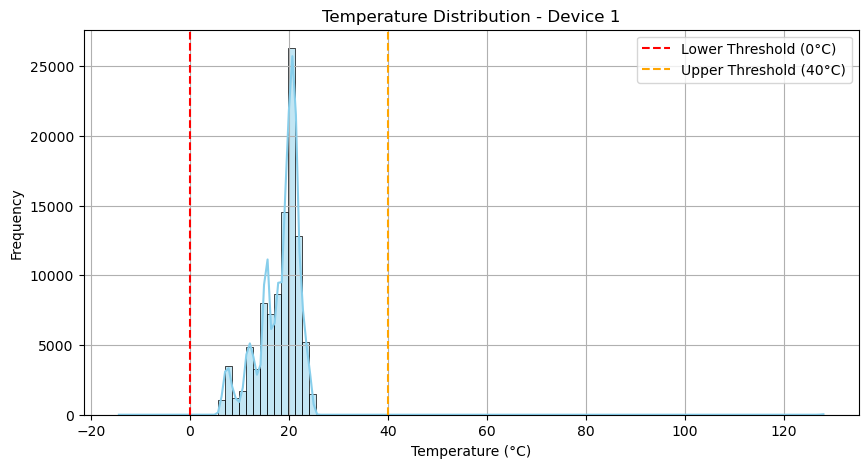

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df1['temperature'], bins=100, kde=True, color='skyblue')

# Add vertical lines for outlier thresholds
plt.axvline(0, color='red', linestyle='--', label='Lower Threshold (0°C)')
plt.axvline(40, color='orange', linestyle='--', label='Upper Threshold (40°C)')

plt.title('Temperature Distribution - Device 1')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


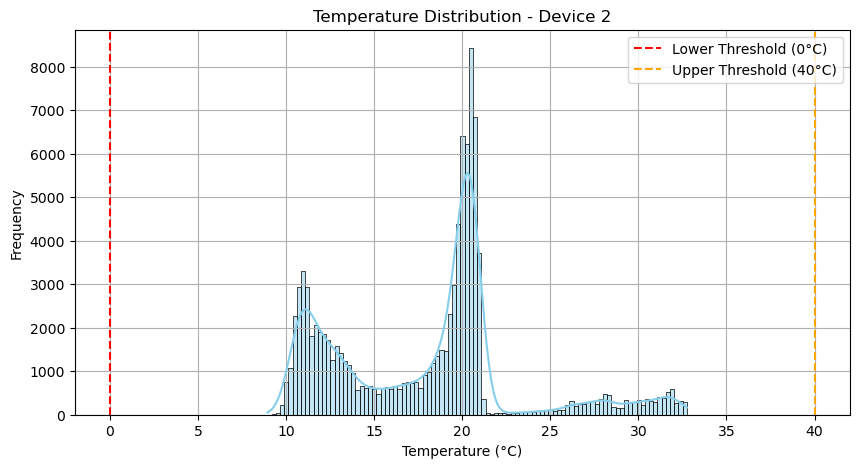

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(df2['temperature'], bins=100, kde=True, color='skyblue')

# Add vertical lines for outlier thresholds
plt.axvline(0, color='red', linestyle='--', label='Lower Threshold (0°C)')
plt.axvline(40, color='orange', linestyle='--', label='Upper Threshold (40°C)')

plt.title('Temperature Distribution - Device 2')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


#### Handle invalid data in Decive 1

In [22]:
# Count invalid temperatures
invalid_mask = (df1['temperature'] < 0) | (df1['temperature'] > 40)
invalid_count = invalid_mask.sum()

print(f"Number of invalid temperature entries: {invalid_count}")

Number of invalid temperature entries: 35


This fills invalid values using the last known valid temperature. If the first row is invalid, it will be filled with the next valid one.

In [25]:
df1_fixed = df1.copy()

# Set invalid temperatures as NaN
df1_fixed.loc[invalid_mask, 'temperature'] = np.nan

# Impute using forward fill first, then back fill if needed
df1_fixed['temperature'] = df1_fixed['temperature'].ffill().bfill()

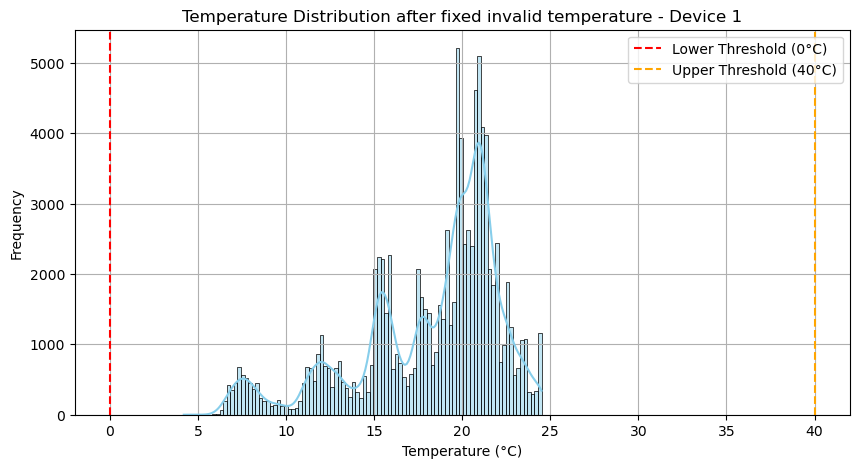

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(df1_fixed['temperature'], bins=100, kde=True, color='skyblue')

# Add vertical lines for outlier thresholds
plt.axvline(0, color='red', linestyle='--', label='Lower Threshold (0°C)')
plt.axvline(40, color='orange', linestyle='--', label='Upper Threshold (40°C)')

plt.title('Temperature Distribution after fixed invalid temperature - Device 1')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### 2. Pattern Analysis with Machine Learning

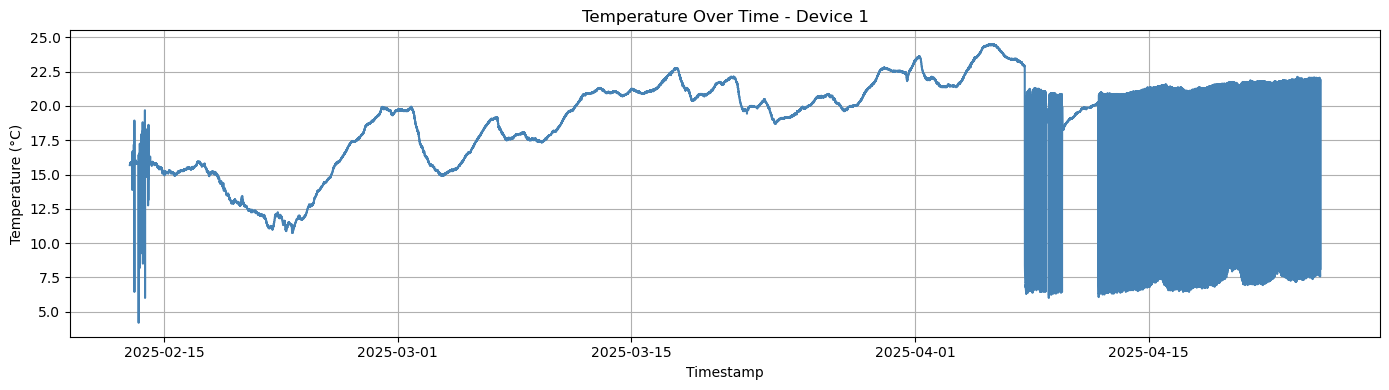

In [33]:
plt.figure(figsize=(14, 4))
plt.plot(df1_fixed['timestamp'], df1_fixed['temperature'], color='steelblue')
plt.title('Temperature Over Time - Device 1')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

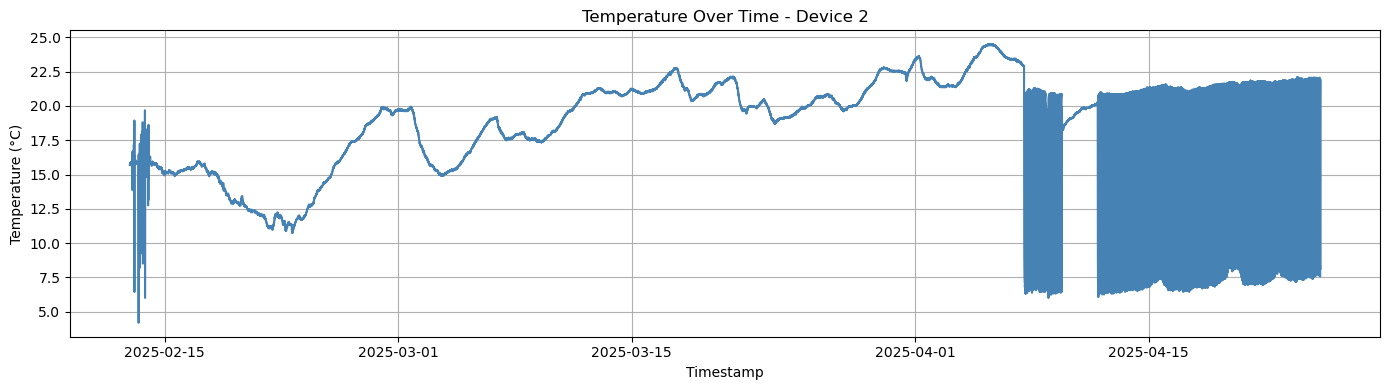

In [29]:
plt.figure(figsize=(14, 4))
plt.plot(df2['timestamp'], df1_fixed['temperature'], color='steelblue')
plt.title('Temperature Over Time - Device 2')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Narrow the range to April 13–20
mask_april = (df1_fixed['timestamp'] >= '2025-04-13') & (df1_fixed['timestamp'] <= '2025-04-20')
df_april = df1_fixed[mask_april]

# Display a sample
df_april.head()


,device_id,timestamp,temperature,delta
82690,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-13 00:00:12,20.812,62.0
82691,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-13 00:01:14,20.875,62.0
82692,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-13 00:02:15,20.875,61.0
82693,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-13 00:03:17,19.750,62.0
82694,7e02595d-d072-46e6-a72c-1deddc8bdb9c,2025-04-13 00:04:19,13.250,62.0


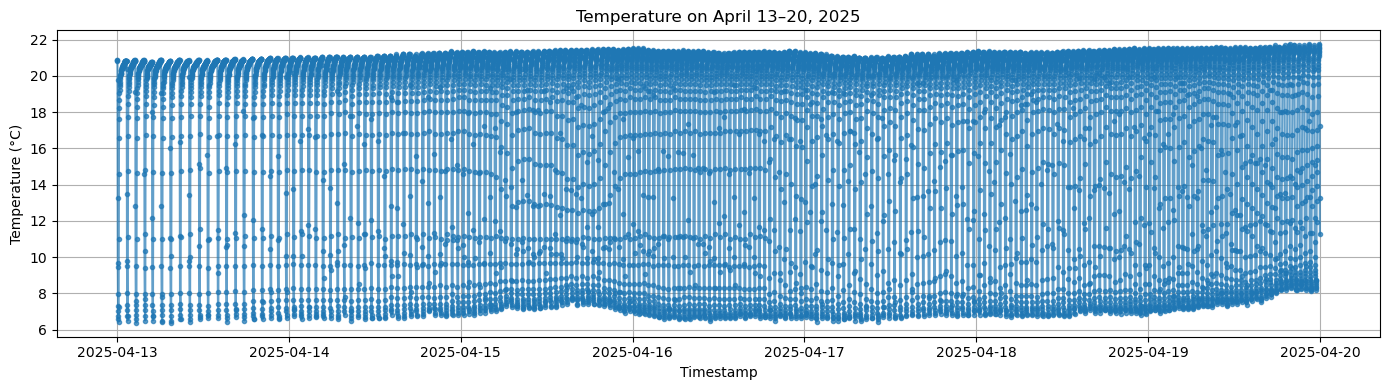

In [41]:
plt.figure(figsize=(14, 4))
plt.plot(df_april['timestamp'], df_april15['temperature'], marker='.', linestyle='-', alpha=0.7)
plt.title("Temperature on April 13–20, 2025")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Ensure timestamp is datetime and set as index
df1_ts = df1_fixed.set_index('timestamp')
df2_ts = df2.set_index('timestamp')

# Resample to 1-minute frequency with interpolation
df1_rs = df1_ts['temperature'].resample('1T').mean().interpolate().reset_index()
df2_rs = df2_ts['temperature'].resample('1T').mean().interpolate().reset_index()

# Add device_id column for identification
df1_rs['device_id'] = 'device_1'
df2_rs['device_id'] = 'device_2'


/var/folders/gq/5v7478z94cjfrvy9shjn1vbw0000gn/T/ipykernel_69263/2973002820.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df1_rs = df1_ts['temperature'].resample('1T').mean().interpolate().reset_index()
/var/folders/gq/5v7478z94cjfrvy9shjn1vbw0000gn/T/ipykernel_69263/2973002820.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df2_rs = df2_ts['temperature'].resample('1T').mean().interpolate().reset_index()


In [66]:
# Filter to the same date range
# Define the date range window
start_date = '2025-04-13'
end_date = '2025-04-20'

# Apply masks separately to each DataFrame
mask1 = (df1_rs['timestamp'] >= start_date) & (df1_rs['timestamp'] <= end_date)
mask2 = (df2_rs['timestamp'] >= start_date) & (df2_rs['timestamp'] <= end_date)

df1_window = df1_rs[mask1].copy()
df2_window = df2_rs[mask2].copy()


# Combine datasets
df_combined = pd.concat([df1_window, df2_window], ignore_index=True)

# Time-based features
df_combined['minute'] = df_combined['timestamp'].dt.minute
df_combined['hour'] = df_combined['timestamp'].dt.hour
df_combined['minute_of_day'] = df_combined['hour'] * 60 + df_combined['minute']

# Daily cycle
df_combined['sin_day'] = np.sin(2 * np.pi * df_combined['minute_of_day'] / 1440)
df_combined['cos_day'] = np.cos(2 * np.pi * df_combined['minute_of_day'] / 1440)

# Hourly cycle
df_combined['sin_hour'] = np.sin(2 * np.pi * df_combined['minute'] / 60)
df_combined['cos_hour'] = np.cos(2 * np.pi * df_combined['minute'] / 60)

# raw minute_of_day
df_combined['minute_of_day_scaled'] = df_combined['minute_of_day'] / 1440  # normalize


### Xgboost Model

#### Train/Test Split by Time

In [67]:
train_mask = df_combined['timestamp'] < '2025-04-19'
test_mask = df_combined['timestamp'] >= '2025-04-19'

features = ['sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'minute_of_day_scaled']

X_train = df_combined.loc[train_mask, features]
y_train = df_combined.loc[train_mask, 'temperature']

X_test = df_combined.loc[test_mask, features]
y_test = df_combined.loc[test_mask, 'temperature']


In [68]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [69]:
df_combined.loc[train_mask, 'predicted'] = model.predict(X_train)
df_combined.loc[test_mask, 'predicted'] = model.predict(X_test)

mse = mean_squared_error(y_test, df_combined.loc[test_mask, 'predicted'])
r2 = r2_score(y_test, df_combined.loc[test_mask, 'predicted'])

print(f"XGBoost Test MSE: {mse:.4f}")
print(f"XGBoost Test R²: {r2:.4f}")


XGBoost Test MSE: 26.4739
XGBoost Test R²: -0.2567


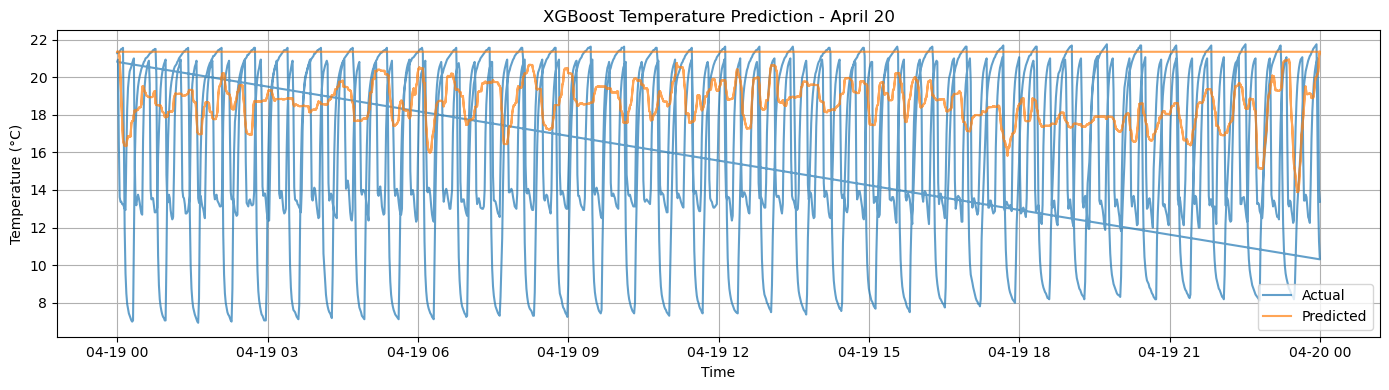

In [70]:
plt.figure(figsize=(14, 4))
plt.plot(df_combined.loc[test_mask, 'timestamp'], y_test, label='Actual', alpha=0.7)
plt.plot(df_combined.loc[test_mask, 'timestamp'], df_combined.loc[test_mask, 'predicted'], label='Predicted', alpha=0.7)
plt.title('XGBoost Temperature Prediction - April 20')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LSTM

In [92]:
from sklearn.preprocessing import MinMaxScaler

# Use only 1 device first (e.g., df1_resampled)
df_lstm = df1_rs.copy()
df_lstm = df_lstm[(df_lstm['timestamp'] >= '2025-04-13') & (df_lstm['timestamp'] <= '2025-04-20')].copy()

# Normalize temperature
scaler = MinMaxScaler()
df_lstm['temp_scaled'] = scaler.fit_transform(df_lstm[['temperature']])


In [93]:
# Create sliding window sequences
SEQ_LEN = 90  # 60 minutes

X, y = [], []
for i in range(len(df_lstm) - SEQ_LEN):
    X.append(df_lstm['temp_scaled'].iloc[i:i+SEQ_LEN].values)
    y.append(df_lstm['temp_scaled'].iloc[i+SEQ_LEN])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [94]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30


/Users/zhenglanfeng/opt/anaconda3/envs/genai/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.1697 - val_loss: 0.0235
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0208 - val_loss: 0.0152
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/ste

In [96]:
y_pred = model.predict(X_test)

# Inverse scale to actual temperature
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


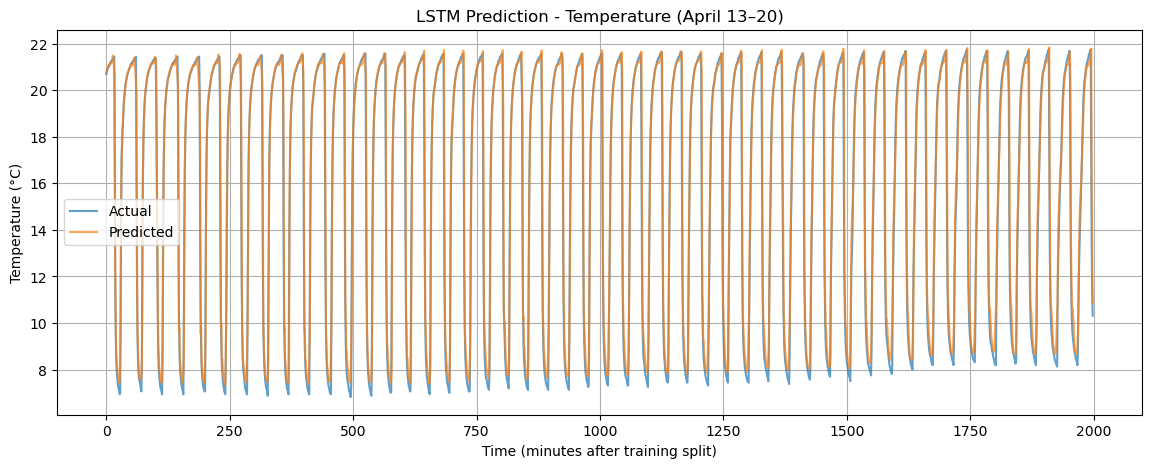

In [97]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual', alpha=0.7)
plt.plot(y_pred_inv, label='Predicted', alpha=0.7)
plt.title('LSTM Prediction - Temperature (April 13–20)')
plt.xlabel('Time (minutes after training split)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [98]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Test MSE: {mse:.4f}")
print(f"LSTM Test R²: {r2:.4f}")


LSTM Test MSE: 0.7946
LSTM Test R²: 0.9748


#### Cycle Period

In [99]:
from scipy.signal import find_peaks

# Use the inverse-scaled actual values for clarity
temperature_series = y_test_inv.flatten()

# Find peaks (tune height/distance if needed)
peaks, _ = find_peaks(temperature_series, distance=30)  # ~30-minute minimum spacing

# Calculate time differences between peaks (in minutes)
peak_intervals = np.diff(peaks)  # unit: minutes since 1 sample = 1 min

avg_cycle_period = np.mean(peak_intervals)
print(f"Average Cycle Period: {avg_cycle_period:.2f} minutes")

Average Cycle Period: 41.21 minutes


#### Amplitude

In [100]:
troughs, _ = find_peaks(-temperature_series, distance=30)

# Pair peaks and troughs to compute amplitude per cycle
paired_amplitudes = []

for p, t in zip(peaks[:len(troughs)], troughs):
    paired_amplitudes.append(abs(temperature_series[p] - temperature_series[t]))

avg_amplitude = np.mean(paired_amplitudes)
print(f"Average Amplitude: {avg_amplitude:.2f} °C")

Average Amplitude: 14.20 °C


Average Cycle Period: ~41.21 minutes  
Average Amplitude: ~14.20 °C


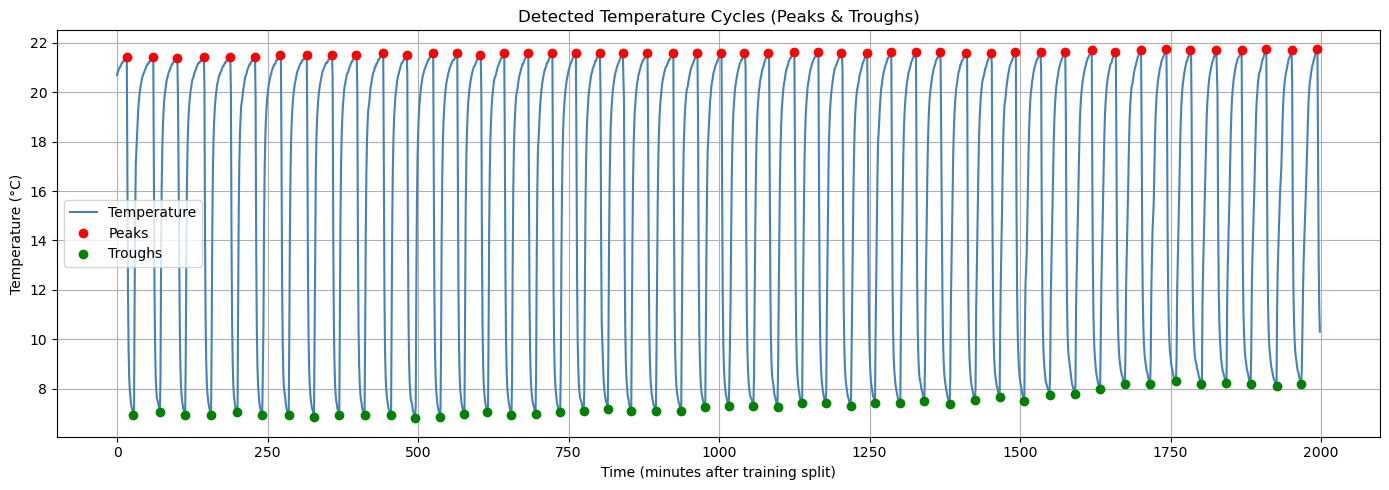

In [101]:
from scipy.signal import find_peaks

# Flatten the temperature series
temps = y_test_inv.flatten()

# Detect peaks and troughs
peaks, _ = find_peaks(temps, distance=30)
troughs, _ = find_peaks(-temps, distance=30)

# Plot temperature series with annotations
plt.figure(figsize=(14, 5))
plt.plot(temps, label='Temperature', color='steelblue')
plt.plot(peaks, temps[peaks], 'ro', label='Peaks')
plt.plot(troughs, temps[troughs], 'go', label='Troughs')

plt.title('Detected Temperature Cycles (Peaks & Troughs)')
plt.xlabel('Time (minutes after training split)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Deviation Detection

In [102]:
# Make sure we're working with inverse-scaled predictions and actuals
df_deviation = pd.DataFrame({
    'actual': y_test_inv.flatten(),
    'predicted': y_pred_inv.flatten()
})

# Calculate absolute error
df_deviation['abs_error'] = np.abs(df_deviation['actual'] - df_deviation['predicted'])

# Flag deviations > 2°C
THRESHOLD = 2.0
df_deviation['is_deviation'] = (df_deviation['abs_error'] > THRESHOLD).astype(int)

# Show a few rows
df_deviation.head()

,actual,predicted,abs_error,is_deviation
0,20.687,20.765320,0.078320,0
1,20.812,20.818518,0.006518,0
2,20.875,20.935324,0.060324,0
3,20.937,20.983608,0.046608,0
4,21.000,21.038870,0.038870,0


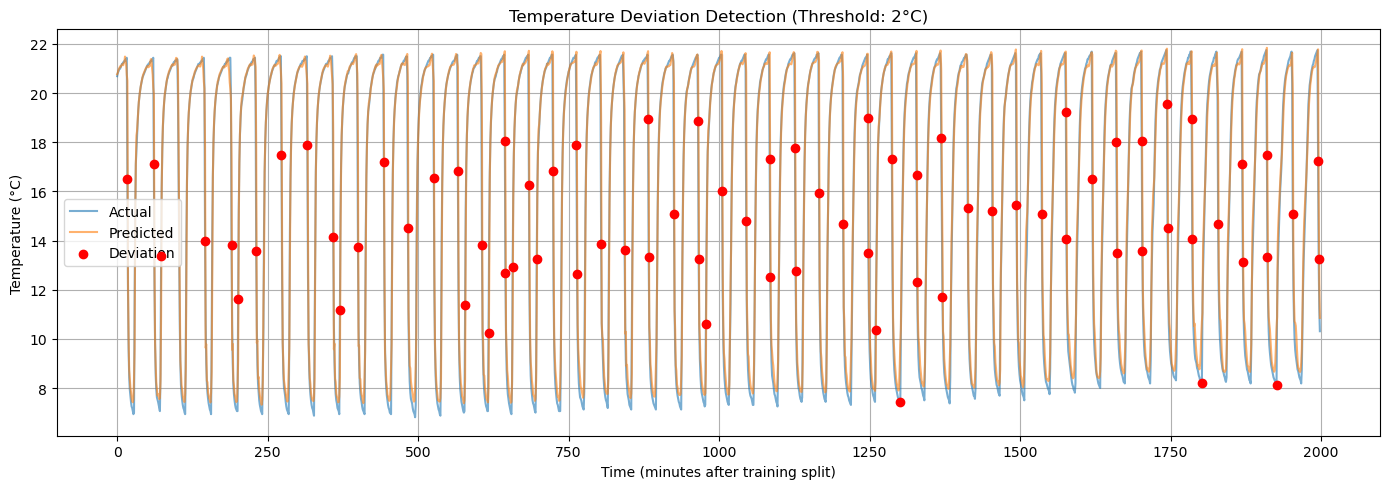

In [103]:
plt.figure(figsize=(14, 5))
plt.plot(df_deviation['actual'], label='Actual', alpha=0.6)
plt.plot(df_deviation['predicted'], label='Predicted', alpha=0.6)
plt.scatter(df_deviation.index[df_deviation['is_deviation'] == 1],
            df_deviation.loc[df_deviation['is_deviation'] == 1, 'actual'],
            color='red', label='Deviation', zorder=10)

plt.title('Temperature Deviation Detection (Threshold: 2°C)')
plt.xlabel('Time (minutes after training split)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [104]:
df_alerts = df_deviation[df_deviation['is_deviation'] == 1]
df_alerts.head()


,actual,predicted,abs_error,is_deviation
17,16.500,20.499357,3.999357,1
61,17.125,19.960403,2.835403,1
73,13.375,10.995457,2.379543,1
146,14.000,17.812101,3.812101,1
190,13.812,17.313864,3.501864,1


In [105]:
df_alerts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 17 to 1996
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   actual        77 non-null     float64
 1   predicted     77 non-null     float32
 2   abs_error     77 non-null     float64
 3   is_deviation  77 non-null     int64  
dtypes: float32(1), float64(2), int64(1)
memory usage: 2.7 KB


### 4. Visualization

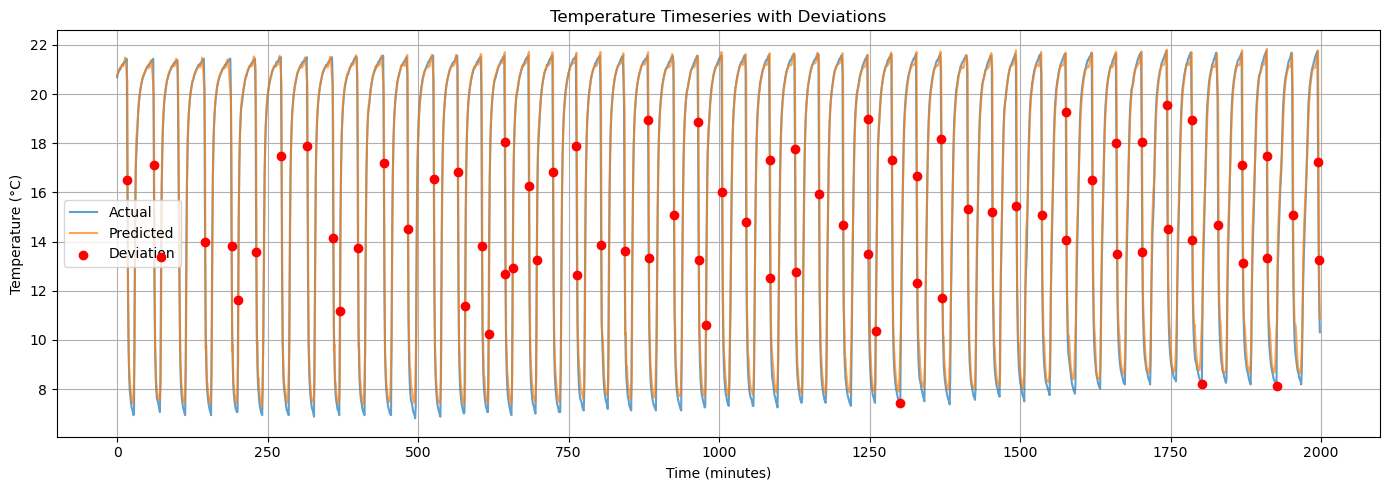

In [107]:
# Time-series plot with deviation markers
plt.figure(figsize=(14, 5))
plt.plot(df_deviation['actual'], label='Actual', alpha=0.7)
plt.plot(df_deviation['predicted'], label='Predicted', alpha=0.7)
plt.scatter(df_deviation.index[df_deviation['is_deviation'] == 1],
            df_deviation.loc[df_deviation['is_deviation'] == 1, 'actual'],
            color='red', label='Deviation', zorder=10)
plt.title('Temperature Timeseries with Deviations')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('timeseries.png')

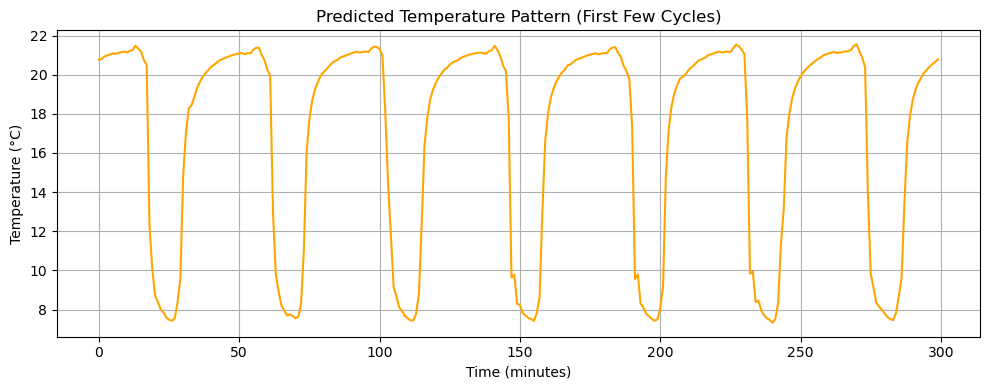

In [108]:
# Zoomed-in cycle pattern (first 3–4 cycles)
plt.figure(figsize=(10, 4))
plt.plot(df_deviation['predicted'][:300], label='Predicted', color='orange')
plt.title('Predicted Temperature Pattern (First Few Cycles)')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.savefig('cycle_pattern.png')

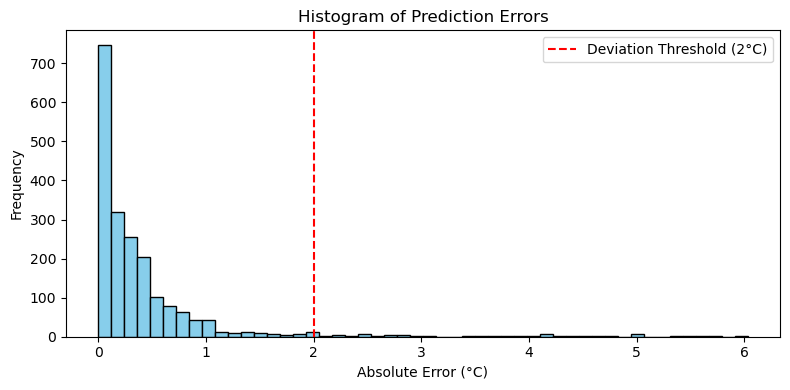

In [109]:
# Error histogram
plt.figure(figsize=(8, 4))
plt.hist(df_deviation['abs_error'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=THRESHOLD, color='red', linestyle='--', label='Deviation Threshold (2°C)')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Absolute Error (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('error_histogram.png')

### 5. Alerting Rules

Threshold-based rule: If |actual - predicted| > 2°C, raise an alert.

In [111]:
df_deviation['timestamp'] = df_combined.loc[test_mask].reset_index(drop=True)['timestamp']

# Filter deviation alerts
df_alerts = df_deviation[df_deviation['is_deviation'] == 1].copy()

# Add explanation column
df_alerts['reason'] = df_alerts['abs_error'].apply(lambda x: f"Deviation exceeds threshold by {x:.2f}°C")

# Reorder and clean columns
df_alerts = df_alerts[['timestamp', 'actual', 'predicted', 'abs_error', 'reason']]
df_alerts.columns = ['Timestamp', 'Actual (°C)', 'Predicted (°C)', 'Deviation Magnitude', 'Reason']

df_alerts.head()


,Timestamp,Actual (°C),Predicted (°C),Deviation Magnitude,Reason
17,2025-04-19 00:17:00,16.500,20.499357,3.999357,Deviation exceeds threshold by 4.00°C
61,2025-04-19 01:01:00,17.125,19.960403,2.835403,Deviation exceeds threshold by 2.84°C
73,2025-04-19 01:13:00,13.375,10.995457,2.379543,Deviation exceeds threshold by 2.38°C
146,2025-04-19 02:26:00,14.000,17.812101,3.812101,Deviation exceeds threshold by 3.81°C
190,2025-04-19 03:10:00,13.812,17.313864,3.501864,Deviation exceeds threshold by 3.50°C


In [112]:
df_alerts.to_csv('deviation_alerts.csv', index=False)

### 6. Output and Report

In [114]:
# Filter and prepare test period data
df_export = df_combined.loc[test_mask, ['device_id', 'timestamp', 'temperature']].copy()
df_export['predicted_temperature'] = df_combined.loc[test_mask, 'predicted'].values

# Format timestamp
df_export['timestamp'] = df_export['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Flag deviations
df_export['abs_error'] = np.abs(df_export['temperature'] - df_export['predicted_temperature'])
df_export['is_deviation'] = (df_export['abs_error'] > 2.0).astype(int)

# Reorder columns
df_export = df_export[['device_id', 'timestamp', 'temperature', 'predicted_temperature', 'is_deviation']]

# Save a CSV per device
device_ids = df_export['device_id'].unique()

for device in device_ids:
    df_device = df_export[df_export['device_id'] == device]
    filename = f'temperature_output_{device}.csv'
    df_device.to_csv(filename, index=False)
    print(f'Saved: {filename}')


Saved: temperature_output_device_1.csv
Saved: temperature_output_device_2.csv


### 7. Bonus: Motor Current Analysis

In [115]:
# Load data
df_motor = pd.read_csv('motor-data-device-3.csv')
df_motor['timestamp'] = pd.to_datetime(df_motor['ts'], unit='ms')
df_motor = df_motor[['timestamp', 'motor_current']].copy()

In [117]:
df_motor.head(20)

,timestamp,motor_current
0,2025-04-25 06:01:01.940,0.000
1,2025-04-25 06:01:00.298,24.833
2,2025-04-25 06:00:56.187,24.769
3,2025-04-25 06:00:52.076,24.817
4,2025-04-25 06:00:48.784,24.721
5,2025-04-25 06:00:44.673,24.815
6,2025-04-25 06:00:40.562,24.828
7,2025-04-25 06:00:36.451,24.827
8,2025-04-25 06:00:32.340,24.806
9,2025-04-25 06:00:28.228,24.839


In [134]:
# Resample to 100 milliseconds interval
df_motor.set_index('timestamp', inplace=True)
df_motor = df_motor.resample('10S').mean().interpolate()
df_motor.reset_index(inplace=True)

/var/folders/gq/5v7478z94cjfrvy9shjn1vbw0000gn/T/ipykernel_69263/1754670151.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_motor = df_motor.resample('10S').mean().interpolate()


In [135]:
# Filter to April 13–24, 2025
start_date = '2025-04-13'
end_date = '2025-04-14'
mask = (df_motor['timestamp'] >= start_date) & (df_motor['timestamp'] <= end_date)
df_motor_window = df_motor[mask].copy()

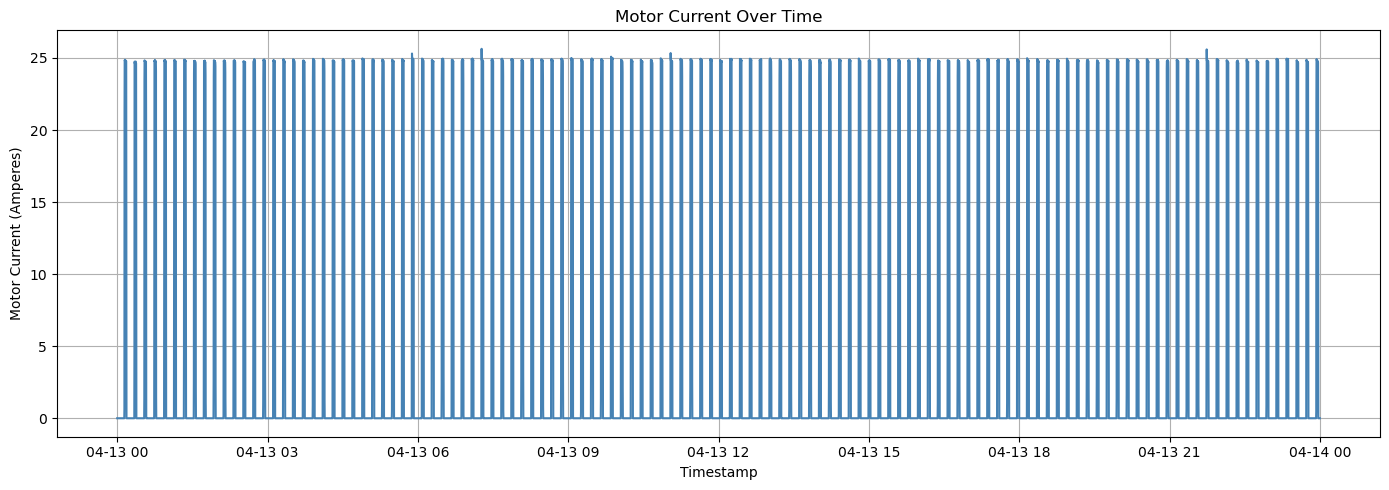

In [136]:
plt.figure(figsize=(14, 5))
plt.plot(df_motor_window['timestamp'], df_motor_window['motor_current'], color='steelblue')
plt.title('Motor Current Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Motor Current (Amperes)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [137]:
df_motor_day = df_motor[
    (df_motor['timestamp'] >= '2025-04-13') &
    (df_motor['timestamp'] < '2025-04-14')
].copy()


# Normalize
scaler = MinMaxScaler()
df_motor_day['scaled'] = scaler.fit_transform(df_motor_day[['motor_current']])

# Create sequences
SEQ_LEN = 60
X, y = [], []
for i in range(len(df_motor_day) - SEQ_LEN):
    X.append(df_motor_day['scaled'].iloc[i:i+SEQ_LEN].values)
    y.append(df_motor_day['scaled'].iloc[i+SEQ_LEN])
X = np.array(X).reshape((-1, SEQ_LEN, 1))
y = np.array(y)

# Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [138]:
X_train.shape

(6864, 60, 1)

In [147]:
# Build LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0770
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0067
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0035
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0025
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0016
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0024
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0036
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0029
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0017
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0034


In [148]:
# Predict and inverse scale
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [149]:
# Evaluate
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Motor Current Test MSE: {mse:.4f}, R²: {r2:.4f}")

LSTM Motor Current Test MSE: 1.2551, R²: 0.9859


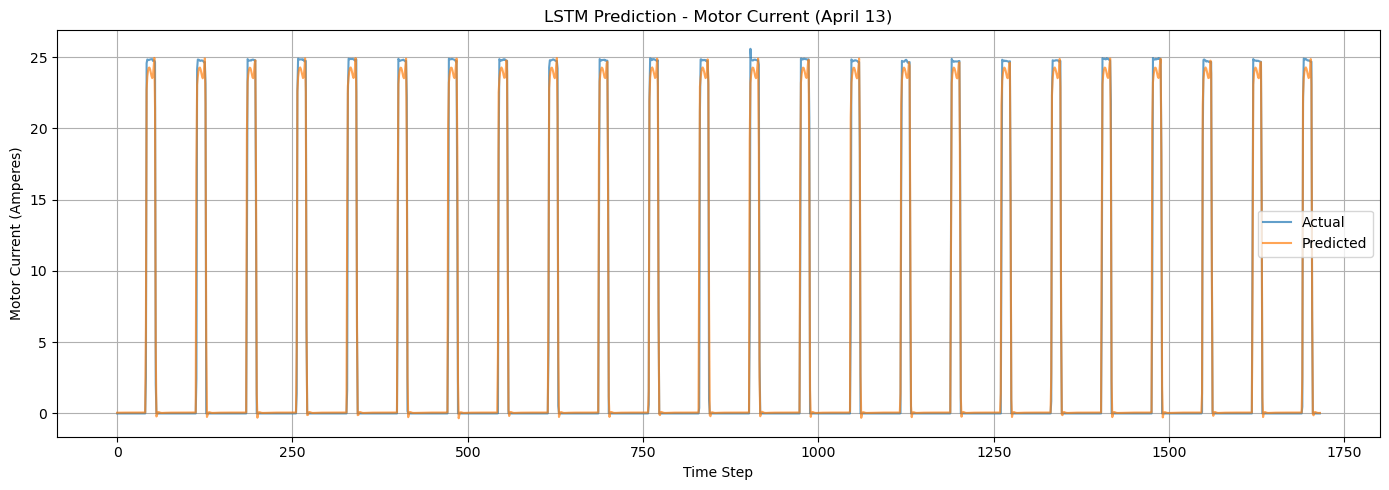

In [150]:
# Plot
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual', alpha=0.7)
plt.plot(y_pred_inv, label='Predicted', alpha=0.7)
plt.title('LSTM Prediction - Motor Current (April 13)')
plt.xlabel('Time Step')
plt.ylabel('Motor Current (Amperes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Pattern

In [156]:
df_cycle = df_motor_day[
    (df_motor_day['timestamp'] >= '2025-04-13 00:00:00') &
    (df_motor_day['timestamp'] <  '2025-04-13 01:00:00')
].copy()

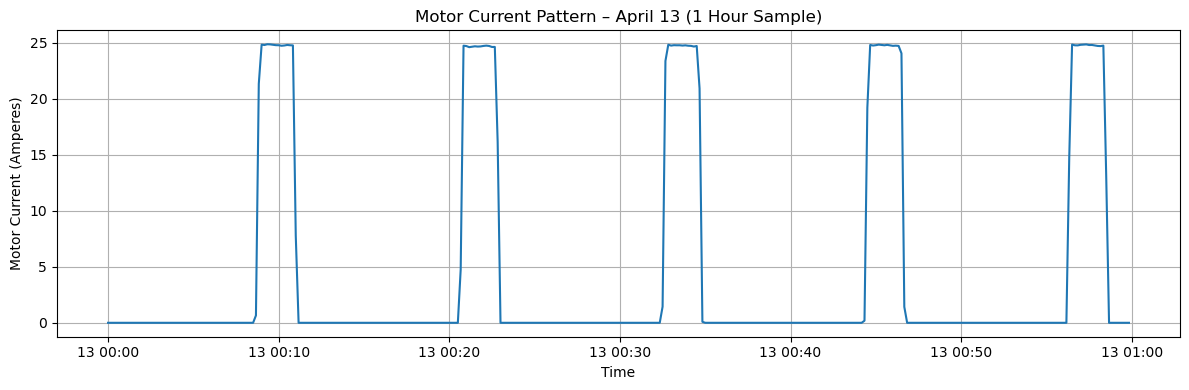

In [157]:
plt.figure(figsize=(12, 4))
plt.plot(df_cycle['timestamp'], df_cycle['motor_current'], label='Motor Current')
plt.title('Motor Current Pattern – April 13 (1 Hour Sample)')
plt.xlabel('Time')
plt.ylabel('Motor Current (Amperes)')
plt.grid(True)
plt.tight_layout()
plt.show()
